In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import os
from glob import glob
import random
import time

import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import ImageGrid
from google.colab.patches import cv2_imshow


plt.style.use("dark_background")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  if sys.path[0] == '':


In [3]:
DATA_PATH = "/content/drive/My Drive/case study/case study 2/lgg-mri-segmentation/kaggle_3m/"
train_files = []
mask_files = glob(DATA_PATH +'*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

In [4]:
len(train_files), len(mask_files)

(3929, 3929)

In [5]:
def pre_process_image(image, mask):
  '''
  This function will take the image and mask as input
  and perform pre-processing steps like cropping and
  applying CLAHE to enhance the contrast of the image
  and returns the pre-processed image and the mask.
  Argument:
  -----------------------
  image - the image path
  mask  - the mask path
  -----------------------
  '''

  image = cv2.imread(image)
  #gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  mask = cv2.imread(mask)
  #imgc = image.copy()
  clahe = cv2.createCLAHE(clipLimit=4, \
                      tileGridSize=(16,16))
  b,g,r = cv2.split(image)

  #apply CLAHE on the three channels separately
  b = clahe.apply(b)
  g = clahe.apply(g)
  r = clahe.apply(r)

  #merge the three channels
  bgr = cv2.merge((b,g,r))

  #convert to RGB
  cl = cv2.cvtColor(bgr,cv2.COLOR_BGR2RGB)
  #edged = clahe.apply(gray_image) 
  imgc = cl.copy() 
  edged = cv2.Canny(cl, 10, 250)

  #cv2.waitKey(0) 

  #edged = cv2.erode(edged, None, iterations=1)
  edged = cv2.dilate(edged, None, iterations=2)

  #applying closing function
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
  closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

  #finding_contours  
  (cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 

  if len(cnts) == 0:
    new_image = imgc
    mask = mask
   
  else:
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    new_image = imgc[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    mask = mask[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

  return new_image, mask

In [6]:
def predict(new_image, mask, infer):
  '''
  Takes the pre-processed image, mask and the loaded model
  as arguments and predicts the output mask.
  Arguments:
  ------------------
  new_image - pre-processed image
  mask      - pre-procesed mask
  infer     - best model for prediction
  ------------------
  '''
  
  #img = cv2.imread(path)
  new_image = cv2.resize(new_image ,(256, 256))
  new_image = new_image / 255
  new_image = new_image[np.newaxis, :, :, :]
  new_image = tf.cast(new_image, tf.float32)
  pred = infer(tf.constant(new_image))['conv2d_29']
  #plt.imshow(np.squeeze(pred) > 0.5)

  plt.figure(figsize=(12,12))
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(new_image))
  plt.title('Original Image')

  #plot the original mask
  plt.subplot(1,3,2)
  #img = cv2.imread(mask_files[idx])
  mask = mask
  img = cv2.resize(mask, (256, 256))
  plt.imshow(np.squeeze(img))
  plt.title('Original Mask')

  #plot the predicted mask
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(pred) > .5)
  plt.title('Prediction')
  plt.show()

In [7]:
def final(img_path, mask_path):
  '''
  This method takes the image path and mask path
  as inputs and perform pre-processing and prediction
  and plot the results.
  Arguments:
  --------------------
  img_path  - the path of the image
  mask_path - the path of the mask
  --------------------
  '''

  #read the image and mask path
  
  image = img_path
  mask = mask_path
  print('[INFO] Loading the image completed...')
  
  #preprocess the image and the mask
  #preprocess include cropping the image, mask
  #and applying CLAHE to enhance the contrast
  
  new_image, new_mask = pre_process_image(image, mask)
  print('[INFO] Pre-processing of the images completed...')
  #load the model
  print('[INFO] Loading the model and predicting...')
  loaded = tf.saved_model.load('/content/drive/My Drive/case study/case study 2/test_final.zip (Unzipped Files)/content/test_saved_model')
  infer = loaded.signatures['serving_default']
  
  #predict the output
  predict(new_image, new_mask, infer)

[INFO] Loading the image completed...
[INFO] Pre-processing of the images completed...
[INFO] Loadin the model and predicting...


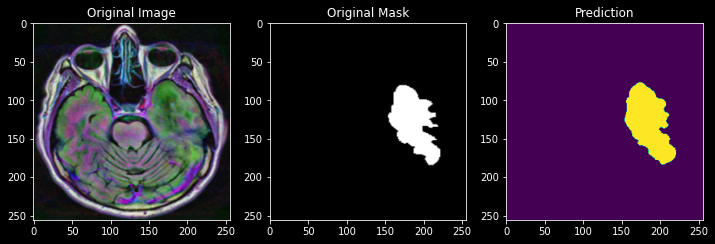

In [8]:
final(train_files[2035], mask_files[2035])

[INFO] Loading the image completed...
[INFO] Pre-processing of the images completed...
[INFO] Loadin the model and predicting...


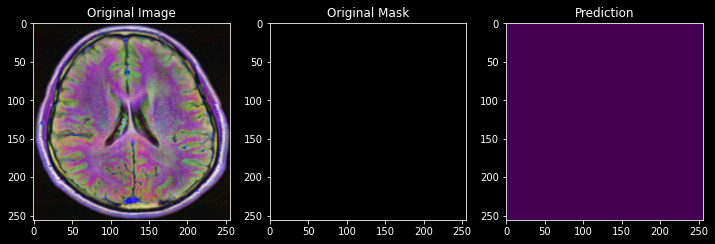

In [9]:
final(train_files[3786], mask_files[3786])